# DIPZ Architecture & Training  Notebook

## The Architecture

In [ ]:
"""
Training DIPZ with keras
"""

# TODO:Clean up these hardcoded values
MERGED_NODES = [32] * 4

# random python utility libs
from argparse import ArgumentParser
from pathlib import Path
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from datetime import datetime

# the data libs
import h5py
import json

# local libs
from layers import Sum
from utils import gaussian_loss
from utils_v5 import mpdf_metric
from utils_v5 import rmse_metric
from utils import TRANSFORMS
from utils import scale
from utils import renamed
from utils import build_feature
from utils import get_gaussian_loss_prec

# mlearnin libs
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, TimeDistributed, Input, Concatenate, Masking
)
#from keras.utils.generic_utils import CustomMaskWarning

# A function to define and gets the config file 
def get_config(config_path):
    with open(config_path) as cfg:
        config = json.load(cfg)
    return dict(
        jetfeatnames=config["jetfeatnames"],
        trackfeatnames=config["trackfeatnames"],
        targetfeatnames=config["targetfeatnames"],
        batch_size=config["batch_size"],
        epoch_size=config["epoch_size"],
        number_epochs=config["num_epochs"],
        learning_rate=config["lr"],
        tracknodes=config['tracknodes'],
        jetnodes=config['jetnodes'],
        jets_container=config['jets_container'],
        tracks_container=config['tracks_container']
    )

# A function that defines and gets the neural network model
def get_model(config, mask_value):
    n_track_inputs = len(config['trackfeatnames'])
    track_inputs = Input(shape=(None,n_track_inputs))

    n_jet_inputs = len(config['jetfeatnames'])
    jet_inputs = Input(shape=(n_jet_inputs))

    # Add jet layers
    x = jet_inputs
    for nodes in config['jetnodes']:
        x = Dense(units=nodes, activation='relu')(x)
    jet_latent = x

    # Add track layers
    x = track_inputs
    x = Masking(mask_value=mask_value)(x)
    for nodes in config['tracknodes']:
        x = TimeDistributed(Dense(nodes, activation='relu'))(x)
    x = Sum()(x)
    track_latent = x

    # Merge the layers
    merged = Concatenate()([jet_latent, track_latent])
    # TODO: It is not clear how many additional processing layers we should add here
    x = merged
    for nodes in MERGED_NODES:
        x = Dense(nodes, activation='relu')(x)
    out_latent = x
    outputs = keras.layers.Dense(units=2)(out_latent)
    model = keras.Model(
        inputs=[jet_inputs, track_inputs],
        outputs=outputs)
    # print the summary
    model.summary()
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=config['learning_rate']),
                  loss=gaussian_loss,
                  metrics=[mpdf_metric, rmse_metric])
    return model

# A function that imports the dataset we will be working on
def get_dataset(h5file_path, config, mask_value, take_first=False):
    """
    We make some hardcoded transformations to normalize these inputs
    """

    # pt is log-transformed
    # Z0 is divided by 50
    # target is divided by 50

    trf = TRANSFORMS
    # identy function to pass through things that aren't listed above
    def ident(x):
        return x

    sl = slice(None,None,None)
    if take_first:
        sl = slice(0,take_first,None)

    with h5py.File(h5file_path) as h5file:
        # get track array
        td = h5file[config['tracks_container']]
        tfn = config['trackfeatnames']
        # We can pass through NaNs here
        with np.errstate(invalid='ignore'):
            trackstack = [trf.get(x,ident)(td[x,sl,...]) for x in tfn]
        track_array = np.stack(trackstack, axis=2)
        invalid = np.isnan(td['pt',sl])
        track_array[invalid,:] = mask_value

        # get the jet array
        jd = h5file[config['jets_container']]
        jfn = config['jetfeatnames']
        jetstack = [trf.get(x,ident)(jd[x,sl]) for x in jfn]
        jet_array = np.stack(jetstack, axis=1)

        # get targets
        tfn = config['targetfeatnames']
        targetstack = [trf.get(x,ident)(jd[x,sl]) for x in tfn]
        target_array = np.stack(targetstack, axis=1)

    return jet_array, track_array, target_array


# A function that gets the inputs to save them
def get_inputs(jet_feature_names, track_feature_names):
    track_variables = [build_feature(x) for x in track_feature_names]
    jet_variables = [build_feature(x) for x in jet_feature_names]
    return {
        'input_sequences': [
            {
                'name': 'SuperROI_tracks',
                'variables': track_variables,
            }
        ],
        'inputs': [
            {
                'name': 'SuperROIs',
                'variables': jet_variables
            }
        ],
        'outputs': [
            {
                'labels': ['z','negLogSigma2'],
                'name': 'dipz'
            }
        ]
    }

# A function that saves the model
def save_model(model, output_dir, inputs):
    current_time = datetime.now().strftime("%Y%m%dT%H%M")
    output_dir.mkdir(exist_ok=True,  parents=True)
    with open(output_dir / f'architecture_{current_time}.json', 'w') as arch:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            arch.write(model.to_json(indent=2))

    model.save_weights(output_dir / f'weights_{current_time}.h5')

    with open(output_dir / f'inputs_{current_time}.json', 'w') as inputs_file:
        json.dump(inputs, inputs_file, indent=2)
        
# A function that takes in 
# 1. A config file paths
# 2. A training sample paths
# and then runs the neural network training and saves the weights
def train(config="../Configs/regress_v2.json", training_sample = "../../../Datasets/user.viruelas.27383479._000001.output.h5"):
    mask_value = 999  #TODO: Clean up these hardcoded values
    config = get_config(config)
    model = get_model(config, mask_value=mask_value)
    jet_inputs, track_inputs, targets = get_dataset(
    training_sample, config, mask_value)
    history = model.fit([jet_inputs, track_inputs], 
                        targets, 
                        epochs=config['number_epochs'], 
                        validation_split = 0.2)
    inputs = get_inputs(config['jetfeatnames'], config['trackfeatnames'])
    current_time = datetime.now().strftime("%Y%m%dT%H%M")
    save_model(model, inputs=inputs, output_dir=Path(f'../Outputs/Outputs_{current_time}/'))
    return history

## Running the training

In [2]:
%%time 

# Provide a path to your config file and to your training sample in the train() function
history = train("../Configs/regress_v2.json", "../../../Datasets/user.viruelas.27383479._000001.output.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 8)]            0         []                            
                                                                                                  
 masking (Masking)           (None, None, 8)              0         ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, None, 16)             144       ['masking[0][0]']             
 ributed)                                                                                     

## Accessing training performance results

In [3]:
# Access training loss, validation loss, mean absolute error, and validation mean absolute error values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
rmse_metric = history.history['rmse_metric']
val_rmse_metric = history.history['val_rmse_metric']
mpdf_metric = history.history['mpdf_metric']
val_mpdf_metric = history.history['val_mpdf_metric']

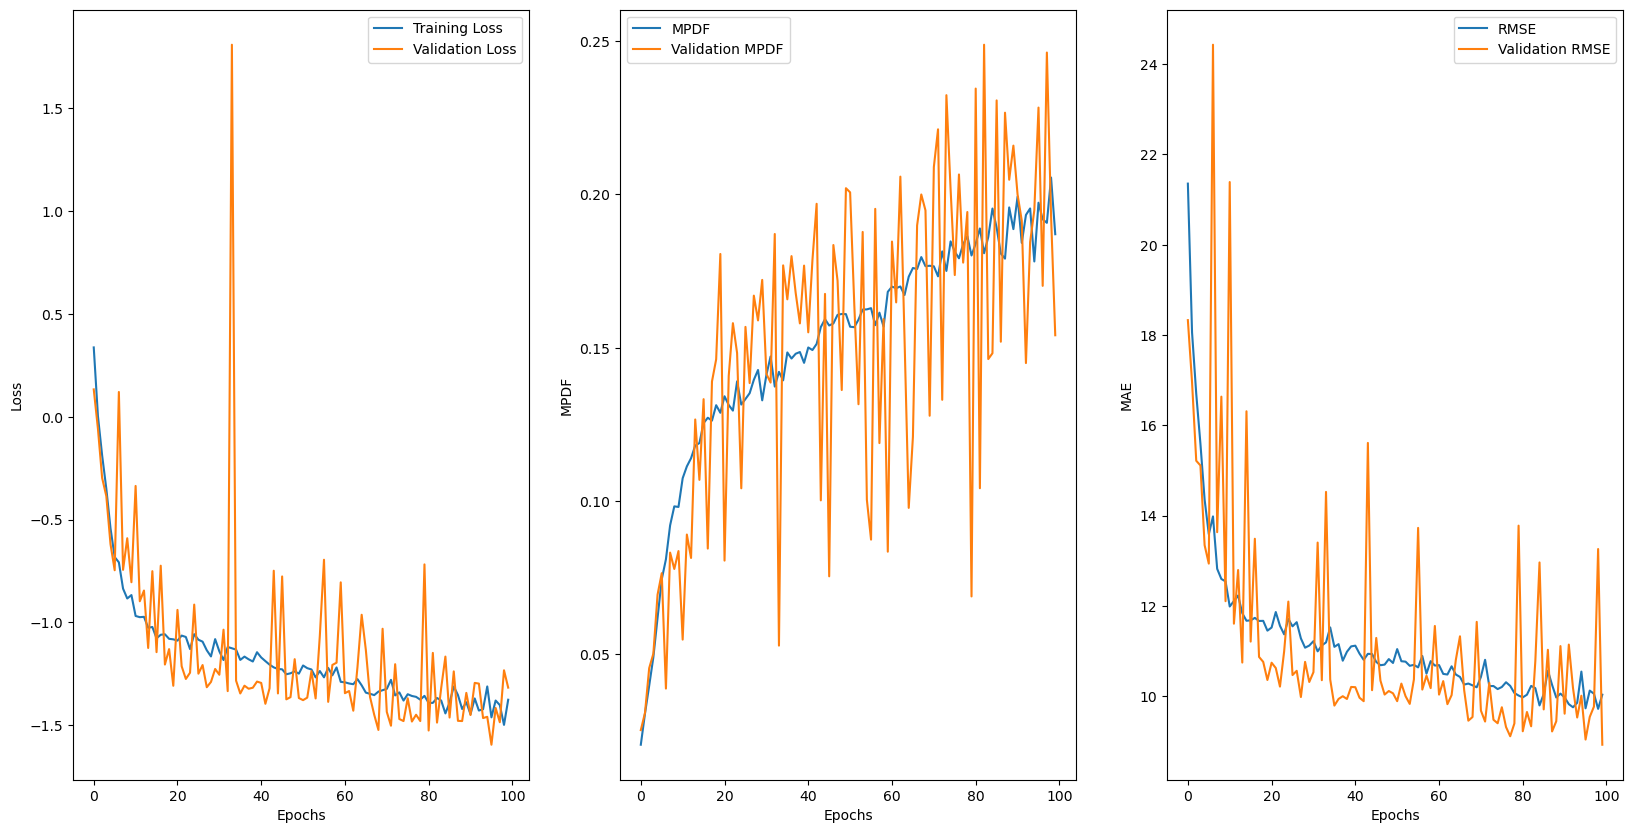

In [4]:
# Plot all three metrics on one canvas
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
# Plot the training loss and validation loss
plt.subplot(1, 3, 1)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Plot the mean pdf and validation mean pdf 
plt.subplot(1, 3, 2)
plt.plot(mpdf_metric, label='MPDF')
plt.plot(val_mpdf_metric, label='Validation MPDF')
plt.xlabel('Epochs')
plt.ylabel('MPDF')
plt.legend()
# Plot the root mean square error and validation root mean square error 
plt.subplot(1, 3, 3)
plt.plot(rmse_metric, label='RMSE')
plt.plot(val_rmse_metric, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
current_time = datetime.now().strftime("%Y%m%dT%H%M")
plt.savefig(f"../Outputs/Outputs_{current_time}/training_plots_{current_time}.png")